In [1]:
# limit compare of dt, csc, 2tag
import ROOT as rt
# import root_numpy as rtnp
import csv
import re
import sys
import collections
import os
from collections import OrderedDict
import uproot
import pandas as pd

import scipy
import awkward
import numpy as np
import time
import numba
from numba import jit
from matplotlib import pyplot as plt
sys.path.append('/storage/af/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/lib/')
from histo_utilities import create_TH1D, create_TH2D, std_color_list, create_TGraph, make_ratio_plot

import CMS_lumi, tdrstyle
tdrstyle.setTDRStyle()
# CMS_lumi.writeExtraText = 0



# donotdelete = []
print(sys.version)

Welcome to JupyROOT 6.18/02
3.6.8 (default, Aug  7 2019, 17:28:10) 
[GCC 4.8.5 20150623 (Red Hat 4.8.5-39)]


# Load ntuples

In [2]:
limitTrees_csc =OrderedDict()
dataCards_csc = OrderedDict()
limitTrees_dt =OrderedDict()
dataCards_dt = OrderedDict()
limitTrees_2tag =OrderedDict()
dataCards_2tag = OrderedDict()

limitTrees_comb =OrderedDict()
dataCards_comb = OrderedDict()


samples = [
# 'allProd_withggZH_HToSS_SToEE_ms0p4',
# 'allProd_withggZH_HToSS_SToGammaGamma_ms0p4',
# 'allProd_withggZH_HToSS_SToKPlusKMinus_ms1p5',
# 'allProd_withggZH_HToSS_SToK0K0_ms1p5',
# 'allProd_withggZH_HToSS_SToPi0Pi0_ms0p4',
# 'allProd_withggZH_HToSS_SToPi0Pi0_ms1p0',
# 'allProd_withggZH_HToSS_SToPiPlusPiMinus_ms0p4',
# 'allProd_withggZH_HToSS_SToPiPlusPiMinus_ms1p0',
# 'allProd_withggZH_HToSS_STodd_ms3p0',
# 'allProd_withggZH_HToSS_STodd_ms7',
'allProd_withggZH_HToSS_STodd_ms15',
'allProd_withggZH_HToSS_STodd_ms40',
'allProd_withggZH_HToSS_STodd_ms55',
'allProd_withggZH_HToSS_SToTauTau_ms7',
'allProd_withggZH_HToSS_SToTauTau_ms15',
'allProd_withggZH_HToSS_SToTauTau_ms40',
'allProd_withggZH_HToSS_SToTauTau_ms55',
'allProd_withggZH_HToSS_SToBB_ms15',
'allProd_withggZH_HToSS_SToBB_ms40',
'allProd_withggZH_HToSS_SToBB_ms55'
]





#### CSC limits

version = '/V1p17/v2/v181/'
dc_version = 'v18'
bdt_name = 'cut_based_v4'
dataCardDir_csc = '/storage/af/user/christiw/login-1/christiw/LLP/CMSSW_10_2_13/src/HiggsAnalysis/MuonSystemLimit/combine/datacards/'+version+'/'+bdt_name+'/'+dc_version+'/'
limitDir_csc = dataCardDir_csc.replace('datacards', 'limitTrees')


#### 2tag limits
version='/V1p17/v2/v181/'
dc_version='v16'
dataCardDir_2tag = '/storage/af/user/christiw/login-1/christiw/LLP/CMSSW_10_2_13/src/HiggsAnalysis/MuonSystemLimit/combine/datacards_2tag/'+version+'/'+dc_version+'/'
limitDir_2tag = dataCardDir_2tag.replace('datacards_2tag', 'limitTrees_2tag')


#### combination limits
dataCardDir_comb = dataCardDir_2tag.replace('datacards_2tag', 'combined_datacards')
limitDir_comb = limitDir_2tag.replace('limitTrees_2tag', 'combined_limitTrees')
    
limitDtDir = '/storage/af/user/christiw/login-1/christiw/LLP/CMSSW_10_2_13/src/HiggsAnalysis/MuonSystemLimit/combine/limitTrees_dt/'
dataCardDtDir = '/storage/af/user/christiw/login-1/christiw/LLP/CMSSW_10_2_13/src/HiggsAnalysis/MuonSystemLimit/combine/datacards_dt/'
dt_version = 'V10v2'
dataCardDir_dt = '/storage/af/user/christiw/login-1/christiw/LLP/CMSSW_10_2_13/src/HiggsAnalysis/MuonSystemLimit/combine/datacards_dt/'
limitDir_dt = '/storage/af/user/christiw/login-1/christiw/LLP/CMSSW_10_2_13/src/HiggsAnalysis/MuonSystemLimit/combine/limitTrees_dt/' + dt_version+ '/'


ctaus = np.array([1, 3, 5, 10, 20, 30, 40, 50, 60, 100, 200, 300, 500, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 10000, 20000, 30000, 40000, 100000]) #v12
ctaus = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, \
                  20, 30, 40, 50, 60, 70, 80, 90, 100, 200, 300, 400, 500, 600, 700, 800, 900, \
                  1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, \
                  10000, 20000, 30000, 40000, 50000, 60000, 70000, 80000, 90000, \
                  100000, 200000, 300000, 400000, 500000, 600000, 700000, 800000, 900000, \
                  1000000, 2000000, 3000000, 4000000, 5000000, 6000000, 7000000, 8000000, 9000000])
                 
### limit branch: 2.5, 16.0, 50.0, 84.0, 97.5, obs
expected = ['0.025', '0.160','0.500','0.840','0.975']
for m in samples:

    limitTrees_csc[m] = {}
    dataCards_csc[m] = {}
    dataCards_dt[m] = {}
    limitTrees_dt[m] = {}
    dataCards_2tag[m] = {}
    limitTrees_2tag[m] = {}
    dataCards_comb[m] = {}
    limitTrees_comb[m] = {}
    for ct in ctaus:
        name = m
        
        # CSC
        unblind = '/unblind/'

        suffix = 'mm_nRechit130dPhiCluster0p75'
        dataCards_csc[m][ct] = dataCardDir_csc + '/methodB/'+unblind+name+'_ctau'+str(ct)+suffix+'.txt'
        limitTrees_csc[m][ct] = limitDir_csc + '/methodB/'+unblind+'/exp/higgsCombine.'+name+'_ctau'+str(ct)+suffix+'.AsymptoticLimits.mH120.root'
         # 2 tag
        category = '/all_cat/'
        unblind = 'unblindABC'
        suffix = 'mm_nCsc100_nDt80'
        dataCards_2tag[m][ct] = dataCardDir_2tag + '/'+unblind+category+name+'_ctau'+ str(ct) + suffix + '.txt'
        limitTrees_2tag[m][ct] = limitDir_2tag + '/'+unblind+category+'/higgsCombine.'+ name + '_ctau'+str(ct)+ suffix + '.AsymptoticLimits.mH120.root'

        
        # combination
        category = '/all_cat/'
        unblind = 'unblindABC'
        suffix = 'mm'
        dataCards_comb[m][ct] = dataCardDir_comb + '/'+unblind+category+name+'_ctau'+ str(ct) + suffix + '.txt'
        limitTrees_comb[m][ct] = limitDir_comb + '/'+unblind+category+'/higgsCombine.'+ name + '_ctau'+str(ct)+ suffix + '.AsymptoticLimits.mH120.root'
#     for ct in ctaus_dt:
        
        # DT
        if 'dd' in m:
            directory = 'TH4dLimits' + dt_version + '/cards/'
        elif  'Tau' in m: directory = 'TH4tauLimits' + dt_version + '/cards/'
        else:continue
        suffix = 'mm'
        mass = m[m.find('ms')+2:]
        dataCards_dt[m][ct] = dataCardDir_dt + directory  +'card_TH_'+str(mass)+'_'+str(ct)+'_renamed.txt'
        limitTrees_dt[m][ct] = limitDir_dt +'/higgsCombine.'+ name + '_ctau'+str(ct)+ suffix + '.AsymptoticLimits.mH120.root'

# 0v2/higgsCombine.allProd_withggZH_HToSS_STodd_ms55_ctau70000mm.AsymptoticLimits.mH120.root
#         higgsCombine.card_TH_15_80_renamed.AsymptoticLimits.mH120.root
norms = []

limits_dt = {}
limits_csc = {}
limits_2tag = {}
limits_comb = {}


for i,m in enumerate(limitTrees_csc.keys()):
    limits_csc[m] = np.ones((len(ctaus), 5))*1000000
    for j, k in enumerate(limitTrees_csc[m].keys()):
        if not os.path.isfile(dataCards_csc[m][k]):
            print(dataCards_csc[m][k])
            continue
        if not os.path.isfile(limitTrees_csc[m][k]):
            print(limitTrees_csc[m][k])
            continue

        line = open(dataCards_csc[m][k], "r").readline()
        signal_norm = float(line.split(" ")[3])
        if signal_norm == 0:continue
        if len(uproot.open(limitTrees_csc[m][k]).keys()) == 2:
            T = uproot.open(limitTrees_csc[m][k])['limit']
            if len(np.array(T.array('limit'))) == 5:limits_csc[m][j] = np.array(T.array('limit'))/signal_norm
    limits_csc[m] = np.array(limits_csc[m])
    
for i,m in enumerate(limitTrees_dt.keys()):
    limits_dt[m] = np.ones((len(ctaus), 6))*1000000
    for j, k in enumerate(limitTrees_dt[m].keys()):
        if not os.path.isfile(dataCards_dt[m][k]):
            continue
        if not os.path.isfile(limitTrees_dt[m][k]):
            print(limitTrees_dt[m][k])
            continue
        line = open(dataCards_dt[m][k], "r").readline()
        if not line.split(" ")[0] == '#' :continue
        signal_norm = float(line.split(" ")[3])
        if signal_norm == 0:continue
        if len(uproot.open(limitTrees_dt[m][k]).keys()) == 2:
            T = uproot.open(limitTrees_dt[m][k])['limit']
            if len(np.array(T.array('limit'))) >= 6:limits_dt[m][j] = np.array(T.array('limit'))/signal_norm/100
    limits_dt[m] = np.array(limits_dt[m])    

for i,m in enumerate(limitTrees_2tag.keys()):
    limits_2tag[m] = np.ones((len(ctaus), 5))*1000000
    for j, k in enumerate(limitTrees_2tag[m].keys()):
        if not os.path.isfile(dataCards_2tag[m][k]):
            print(dataCards_2tag[m][k])
            continue
        if not os.path.isfile(limitTrees_2tag[m][k]):
            print(limitTrees_2tag[m][k])
            continue
        line = open(dataCards_2tag[m][k], "r").readline()
        if not line.split(" ")[0] == '#' :continue
        signal_norm = float(line.split(" ")[3])
        if signal_norm == 0:continue
        if len(uproot.open(limitTrees_2tag[m][k]).keys()) == 2:
            T = uproot.open(limitTrees_2tag[m][k])['limit']
            if len(np.array(T.array('limit'))) == 5:limits_2tag[m][j] = np.array(T.array('limit'))/signal_norm
    limits_2tag[m] = np.array(limits_2tag[m])    


for i,m in enumerate(limitTrees_comb.keys()):
    limits_comb[m] = np.ones((len(ctaus), 5))*1000000
    for j, k in enumerate(limitTrees_comb[m].keys()):
        if not os.path.isfile(dataCards_comb[m][k]):
            print(dataCards_comb[m][k])
            continue
        if not os.path.isfile(limitTrees_comb[m][k]):
            print(limitTrees_comb[m][k])
            continue
        line = open(dataCards_comb[m][k], "r").readline()
        if not line.split(" ")[0] == '#' :continue
        signal_norm = float(line.split(" ")[3])
        if signal_norm == 0:continue
        if len(uproot.open(limitTrees_comb[m][k]).keys()) == 2:
            T = uproot.open(limitTrees_comb[m][k])['limit']
            if len(np.array(T.array('limit'))) == 5:limits_comb[m][j] = np.array(T.array('limit'))/signal_norm
    limits_comb[m] = np.array(limits_comb[m])    



/storage/af/user/christiw/login-1/christiw/LLP/CMSSW_10_2_13/src/HiggsAnalysis/MuonSystemLimit/combine/limitTrees//V1p17/v2/v181//cut_based_v4/v18//methodB//unblind//exp/higgsCombine.allProd_withggZH_HToSS_STodd_ms15_ctau40000mm_nRechit130dPhiCluster0p75.AsymptoticLimits.mH120.root
/storage/af/user/christiw/login-1/christiw/LLP/CMSSW_10_2_13/src/HiggsAnalysis/MuonSystemLimit/combine/limitTrees//V1p17/v2/v181//cut_based_v4/v18//methodB//unblind//exp/higgsCombine.allProd_withggZH_HToSS_STodd_ms15_ctau400000mm_nRechit130dPhiCluster0p75.AsymptoticLimits.mH120.root
/storage/af/user/christiw/login-1/christiw/LLP/CMSSW_10_2_13/src/HiggsAnalysis/MuonSystemLimit/combine/limitTrees//V1p17/v2/v181//cut_based_v4/v18//methodB//unblind//exp/higgsCombine.allProd_withggZH_HToSS_STodd_ms15_ctau4000000mm_nRechit130dPhiCluster0p75.AsymptoticLimits.mH120.root
/storage/af/user/christiw/login-1/christiw/LLP/CMSSW_10_2_13/src/HiggsAnalysis/MuonSystemLimit/combine/datacards//V1p17/v2/v181//cut_based_v4/v18//m

# load other limit

In [22]:
file_dir = '/storage/af/user/christiw/login-1/christiw/LLP/CMSSW_10_2_13/src/HiggsAnalysis/MuonSystemLimit/data/limits_others/'
ms1_40 = file_dir + 'atlas_mh125_mx40_ms1.csv'
ms2_40 = file_dir + 'atlas_mh125_mx40_ms2.csv'
id55 = file_dir + 'atlas_mh125_mx55_id.csv'
comb40 = file_dir + 'atlas_mh125_mx40_id_cr_ms2.csv'

exo_19_021_bb55 = file_dir + 'exo-19-021_bb_55.csv'
exo_19_021_bb40 = file_dir + 'exo-19-021_bb_40.csv'
exo_19_021_dd55 = file_dir + 'exo-19-021_dd_55.csv'
exo_19_021_dd40 = file_dir + 'exo-19-021_dd_40.csv'
exo_19_021_dd15 = file_dir + 'exo-19-021_dd_15.csv'



atlas_2tag_15 = file_dir + 'atlas_2tag_15.csv'

# took from paper draft v5
exo_20_003_bb55 = file_dir + 'exo-20-003_bb_55.csv'
exo_20_003_bb40 = file_dir + 'exo-20-003_bb_40.csv'
exo_20_003_bb15 = file_dir + 'exo-20-003_bb_15.csv'
exo_20_003_dd55 = file_dir + 'exo-20-003_dd_55.csv'
exo_20_003_dd40 = file_dir + 'exo-20-003_dd_40.csv'
exo_20_003_dd15 = file_dir + 'exo-20-003_dd_15.csv'


ms_40 = file_dir + 'atlas_mh125_mx40_ms.csv'
ms_15 = file_dir + 'atlas_mh125_mx15_ms.csv'
ms_8 = file_dir + 'atlas_mh125_mx8_ms.csv'


other_limits = {}

# other_limits['atlas_ms_40'] = np.genfromtxt(ms_40, delimiter=',')
# other_limits['atlas_ms_15'] = np.genfromtxt(ms_15, delimiter=',')
# other_limits['atlas_ms_8'] = np.genfromtxt(ms_8, delimiter=',')

other_limits['atlas_2tag_15'] = np.genfromtxt(atlas_2tag_15, delimiter=',')




# other_limits = {}
# for k, v in file.items():
#     other_limits[k] = np.genfromtxt(v, delimiter=',')
    
#     other_limits[k] = other_limits[k][other_limits[k][:,0].argsort()]

# # 'ms1_40' = np.genfromtxt(ms1_40, delimiter=',')
# # 'ms2_40' = np.genfromtxt(ms2_40, delimiter=',')
# # 'id55' = np.genfromtxt(id55, delimiter=',')
# # 'comb40' = np.genfromtxt(comb40, delimiter=',')
# other_limits['exo_19_021_bb55'] = np.genfromtxt(exo_19_021_bb55, delimiter=',')
# other_limits['exo_19_021_bb40'] = np.genfromtxt(exo_19_021_bb40, delimiter=',')
# other_limits['exo_19_021_dd55'] = np.genfromtxt(exo_19_021_dd55, delimiter=',')
# other_limits['exo_19_021_dd40'] = np.genfromtxt(exo_19_021_dd40, delimiter=',')
# other_limits['exo_19_021_dd15'] = np.genfromtxt(exo_19_021_dd15, delimiter=',')

# other_limits['exo_20_003_bb55'] = np.genfromtxt(exo_20_003_bb55, delimiter=',')
# other_limits['exo_20_003_bb40'] = np.genfromtxt(exo_20_003_bb40, delimiter=',')
# other_limits['exo_20_003_bb15'] = np.genfromtxt(exo_20_003_bb15, delimiter=',')
# other_limits['exo_20_003_dd55'] = np.genfromtxt(exo_20_003_dd55, delimiter=',')
# other_limits['exo_20_003_dd40'] = np.genfromtxt(exo_20_003_dd40, delimiter=',')
# other_limits['exo_20_003_dd15'] = np.genfromtxt(exo_20_003_dd15, delimiter=',')





# comparison of expected limit

allProd_withggZH_HToSS_SToTauTau_ms15
0.0017500023786110005
0.003580842628093412
0.0019589102820478416
0.0010301509706722297


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::SaveSource>: C++ Macro file: /storage/af/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/limits//V1p17/v2/v181//v16/unblindABC/allProd_withggZH_HToSS_SToTauTau_ms15_comparison.C has been generated
Info in <TCanvas::Print>: png file /storage/af/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/limits//V1p17/v2/v181//v16/unblindABC/allProd_withggZH_HToSS_SToTauTau_ms15_comparison.png has been created
Info in <TCanvas::Print>: pdf file /storage/af/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/limits//V1p17/v2/v181//v16/unblindABC/allProd_withggZH_HToSS_SToTauTau_ms15_comparison.pdf has been created


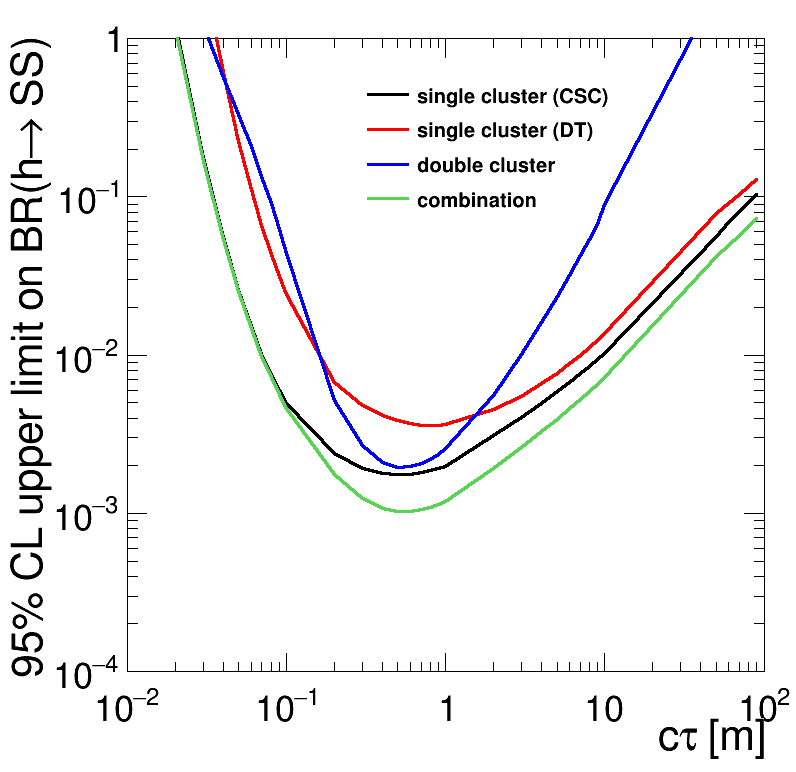

In [18]:
import os
opac_1sig = 0.25
opac_2sig = 0.1
withATLAS = 1

   

for i, m in enumerate(samples):
    if not m == 'allProd_withggZH_HToSS_SToTauTau_ms15':continue
    leg2 = rt.TLegend(0.45,0.72,0.75,0.9)
    leg2.SetTextSize(0.028)
    leg2.SetBorderSize(0)
    leg2.SetEntrySeparation(0.01)
    c = rt.TCanvas('c','c', 800, 800)
    c.SetRightMargin(0.04)
    rt.gStyle.SetOptFit(1011)
    ctaus_m = ctaus/1000
    h_csc = {}
    h_dt = {}
    h_2tag = {}
    h_comb = {}
    upper = 1000000
    print(m)
    cond = limits_csc[m][:,2] < upper
    cond = np.logical_and(cond, limits_2tag[m][:,2] < upper)
#     cond = np.logical_and(cond, limits_comb[m][:,2] < upper)
    cond = np.logical_and(cond, np.logical_not(ctaus_m==20))

    cond = np.logical_and(cond, np.logical_not(ctaus_m==30))
#     cond = np.logical_and(cond, np.logical_not(ctaus_m==0.001))
#     cond = np.logical_and(cond, np.logical_not(ctaus_m==0.01))

#     cond = np.logical_and(cond, np.logical_not(ctaus_m==0.011))
#     cond = np.logical_and(cond, np.logical_not(ctaus_m==0.012))
#     cond = np.logical_and(cond, np.logical_not(ctaus_m==0.013))
#     cond = np.logical_and(cond, np.logical_not(ctaus_m==0.014))

#     cond = np.logical_and(cond, np.logical_not(ctaus_m==0.015))

#     cond = np.logical_and(cond, np.logical_not(ctaus_m==0.016))

#     cond = np.logical_and(cond, np.logical_not(ctaus_m==0.017))




#     cond = np.logical_and(cond, np.logical_not(ctaus_m==0.0125))





    h_csc[m] = create_TGraph(ctaus_m[cond], limits_csc[m][:,2][cond],  axis_title=['c#tau [m]', '95% CL upper limit on BR(h#rightarrow SS)'])
    h_dt[m] = create_TGraph(ctaus_m[cond], limits_dt[m][:,2][cond],  axis_title=['c#tau [m]', '95% CL upper limit on BR(h#rightarrow SS)'])
    h_2tag[m] = create_TGraph(ctaus_m[cond], limits_2tag[m][:,2][cond],  axis_title=['c#tau [m]', '95% CL upper limit on BR(h#rightarrow SS)'])
    h_comb[m] = create_TGraph(ctaus_m[cond], limits_comb[m][:,2][cond],  axis_title=['c#tau [m]', '95% CL upper limit on BR(h#rightarrow SS)'])
    print(np.min(limits_csc[m][:,2][cond]))
    print(np.min(limits_dt[m][:,2][cond]))
    print(np.min(limits_2tag[m][:,2][cond]))
    print(np.min(limits_comb[m][:,2][cond]))

    
    leg2.AddEntry(h_csc[m], "single cluster (CSC)", "LP")
    leg2.AddEntry(h_dt[m], "single cluster (DT)", "L")
    leg2.AddEntry(h_2tag[m], "double cluster", "L")
    leg2.AddEntry(h_comb[m], "combination", "L")


    h_csc[m].SetLineWidth(3)
    h_dt[m].SetLineWidth(3)
    h_2tag[m].SetLineWidth(3)
    h_comb[m].SetLineWidth(3)

    h_csc[m].SetLineColor(std_color_list[0])
    h_dt[m].SetLineColor(std_color_list[1])
    h_2tag[m].SetLineColor(std_color_list[2])
    h_comb[m].SetLineColor(std_color_list[3])

    if 'dd' in m or 'BB' in m or 'TauTau' in m: h_csc[m].GetXaxis().SetLimits(0.01,100.0)
    else: h_csc[m].GetXaxis().SetLimits(0.0001,100.0)
    

    h_csc[m].GetYaxis().SetRangeUser(1e-4,1)


    h_csc[m].Draw('LA')
    h_dt[m].Draw('Lsame')
    h_2tag[m].Draw('Lsame')
    h_comb[m].Draw('Lsame')




    tdrstyle.setTDRStyle()
    CMS_lumi.cmsText     = "CMS"
    iPos = 0
    CMS_lumi.writeExtraText =0
    CMS_lumi.extraText   = "Preliminary"

    if( iPos==0 ): CMS_lumi.relPosX = 0.12
    # CMS_lumi.CMS_lumi(c, 4, 0)
    # CMS_lumi.CMS_lumi(c, 4, iPos)

    # leg.Draw()
    leg2.Draw()
    c.SetLogy()
    c.SetLogx()
    c.SetTicky(1)
    c.SetTickx(1)
    output_dir = '/storage/af/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/limits/'+version+'/'+dc_version+'/'+unblind+'/'
    if not os.path.isdir(output_dir):os.makedirs(output_dir)
    name = output_dir+m+'_comparison'



    # c.SaveAs('test.png')
    c.SaveAs(name+'.C')
    c.SaveAs(name+'.png')
    c.SaveAs(name+'.pdf')

    tdrstyle.setTDRStyle()
c.Draw()


# one mass point

[1.0e-03 2.0e-03 3.0e-03 4.0e-03 5.0e-03 6.0e-03 7.0e-03 8.0e-03 9.0e-03
 1.0e-02 1.1e-02 1.2e-02 1.3e-02 1.4e-02 1.5e-02 1.6e-02 1.7e-02 1.8e-02
 1.9e-02 2.0e-02 3.0e-02 4.0e-02 5.0e-02 6.0e-02 7.0e-02 8.0e-02 9.0e-02
 1.0e-01 2.0e-01 3.0e-01 4.0e-01 5.0e-01 6.0e-01 7.0e-01 8.0e-01 9.0e-01
 1.0e+00 2.0e+00 3.0e+00 4.0e+00 5.0e+00 6.0e+00 7.0e+00 8.0e+00 9.0e+00
 1.0e+01 2.0e+01 3.0e+01 4.0e+01 5.0e+01 6.0e+01 7.0e+01 8.0e+01 9.0e+01
 1.0e+02 2.0e+02 3.0e+02 4.0e+02 5.0e+02 6.0e+02 7.0e+02 8.0e+02 9.0e+02
 1.0e+03 2.0e+03 3.0e+03 4.0e+03 5.0e+03 6.0e+03 7.0e+03 8.0e+03 9.0e+03]
allProd_withggZH_HToSS_STodd_ms15
0.001404373565354636
0.0029128282315392428
0.0007383679701194019
0.0005379159766426888


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file test.png has been created


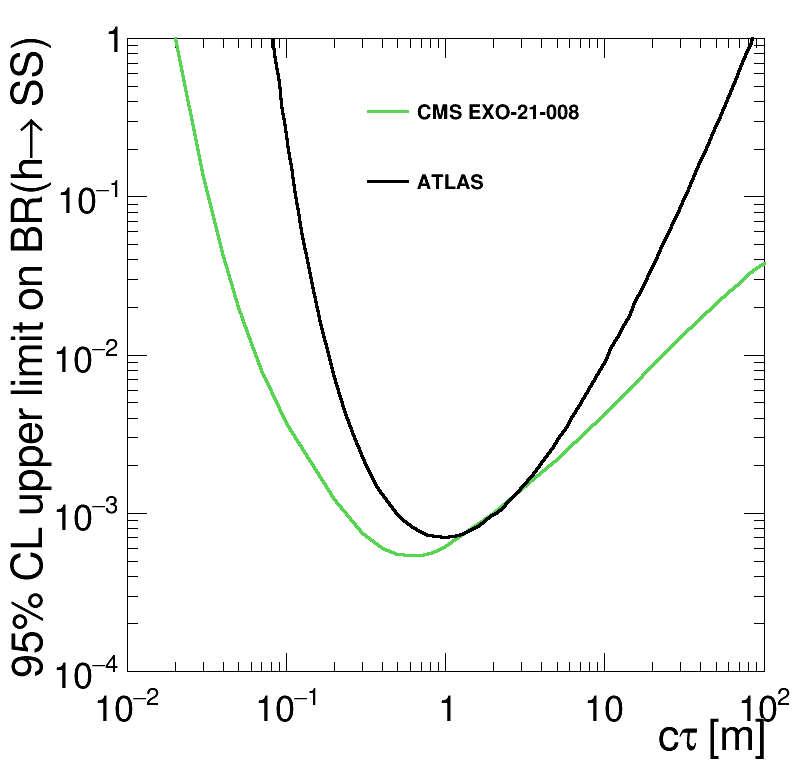

In [5]:
import os
opac_1sig = 0.25
opac_2sig = 0.1
withATLAS = 1

   

leg = rt.TLegend(0.49,0.15,0.88,0.32)
leg.SetTextSize(0.028)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.005)

leg2 = rt.TLegend(0.2,0.15,0.45,0.32)

leg2 = rt.TLegend(0.45,0.72,0.75,0.9)

leg2.SetTextSize(0.028)
leg2.SetBorderSize(0)
leg2.SetEntrySeparation(0.01)
c = rt.TCanvas('c','c', 800, 800)
c.SetRightMargin(0.04)


rt.gStyle.SetOptFit(1011)
ctaus_m = ctaus/1000
print(ctaus_m)
h_csc = {}
h_dt = {}
h_2tag = {}
h_comb = {}
upper = 1000000


for i, m in enumerate(samples):
    if not "15" in m:continue
    print(m)
    cond = limits_csc[m][:,2] < upper
#     cond = np.logical_and(cond, limits_dt[m][:,2] < upper)
    cond = np.logical_and(cond, limits_2tag[m][:,2] < upper)
    cond = np.logical_and(cond, limits_comb[m][:,2] < upper)
    cond = np.logical_and(cond, np.logical_not(ctaus_m==20))

    h_csc[m] = create_TGraph(ctaus_m[cond], limits_csc[m][:,2][cond],  axis_title=['c#tau [m]', '95% CL upper limit on BR(h#rightarrow SS)'])
    h_dt[m] = create_TGraph(ctaus_m[cond], limits_dt[m][:,2][cond],  axis_title=['c#tau [m]', '95% CL upper limit on BR(h#rightarrow SS)'])
    h_2tag[m] = create_TGraph(ctaus_m[cond], limits_2tag[m][:,2][cond],  axis_title=['c#tau [m]', '95% CL upper limit on BR(h#rightarrow SS)'])
    h_comb[m] = create_TGraph(ctaus_m[cond], limits_comb[m][:,2][cond],  axis_title=['c#tau [m]', '95% CL upper limit on BR(h#rightarrow SS)'])
    print(np.min(limits_csc[m][:,2][cond]))
    print(np.min(limits_dt[m][:,2][cond]))
    print(np.min(limits_2tag[m][:,2][cond]))
    print(np.min(limits_comb[m][:,2][cond]))




    leg.AddEntry(h_csc[m], "m_{S} = "+str(mass)+" GeV", "L")
    if i == 0:
#         leg2.AddEntry(h[m], "EXO-20-015", "LP")
#         leg2.AddEntry(h_csc[m], "single cluster (CSC)", "LP")
#         leg2.AddEntry(h_dt[m], "single cluster (DT)", "L")
#         leg2.AddEntry(h_2tag[m], "double cluster", "L")
        leg2.AddEntry(h_comb[m], "CMS EXO-21-008", "L")


    h_csc[m].SetLineWidth(3)
    h_dt[m].SetLineWidth(3)
    h_2tag[m].SetLineWidth(3)

    h_comb[m].SetLineWidth(3)

    
    h_csc[m].SetLineColor(std_color_list[0])
    h_dt[m].SetLineColor(std_color_list[1])
    h_2tag[m].SetLineColor(std_color_list[2])
    h_comb[m].SetLineColor(std_color_list[3])



# #         h_others[m].SetLineStyle(2)
# #         h_others[m].SetLineWidth(3)
#     h[m].GetXaxis().SetLimits(0.01,10000.0)
    h_comb[m].GetXaxis().SetLimits(0.01,100.0)
    h_comb[m].GetYaxis().SetRangeUser(1e-4,1)




for i,m in enumerate(h_csc.keys()):
#     h_csc[m].Draw('LA' if i == 0 else 'Lsame')
#     h_dt[m].Draw('Lsame')
#     h_2tag[m].Draw('Lsame')
    h_comb[m].Draw('LA')
h= {}

h['atlas'] = create_TGraph(other_limits['atlas_2tag_15'][:,0],other_limits['atlas_2tag_15'][:,1],  axis_title=['c#tau [m]', '95% CL Limit on BR'])
leg2.AddEntry(h['atlas'], 'ATLAS')
h['atlas'].SetLineWidth(3)
h['atlas'].Draw('Lsame')


tdrstyle.setTDRStyle()
CMS_lumi.cmsText     = "CMS"
iPos = 0
CMS_lumi.writeExtraText =0
CMS_lumi.extraText   = "Preliminary"

if( iPos==0 ): CMS_lumi.relPosX = 0.12
# CMS_lumi.CMS_lumi(c, 4, 0)
# CMS_lumi.CMS_lumi(c, 4, iPos)

# leg.Draw()
leg2.Draw()
c.SetLogy()
c.SetLogx()
c.SetTicky(1)
c.SetTickx(1)
# output_dir = '/storage/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/limits/'+version+bdt_name+'/'+dc_version+'/'+unblind+'/'
# if not os.path.isdir(output_dir):os.makedirs(output_dir)
# name = output_dir+mode+'_HToSSTo'+decay+'_'+dphi+'_nRechit'+str(nrechit)+'_observed_withATLAS'
# if hybridNew:name += '_hybridNew'
# if CMS_lumi.writeExtraText: name += "_pas"



c.SaveAs('test.png')
# c.SaveAs(name+'.C')
# c.SaveAs(name+'.pdf')

tdrstyle.setTDRStyle()
c.Draw()



# limit for different mass points

In [ ]:
import importlib
importlib.reload(sys.modules['histo_utilities'])
from histo_utilities import create_TH1D, create_TH2D, std_color_list, create_TGraph, make_ratio_plot



# Plotting ncsc
start_t = time.time()

rt.gStyle.SetOptFit(1011)
# for i,k in enumerate(tree_bkg.keys()):
br = 1
ctaus_m = ctaus/1000
print(ctaus_m)
# print(limits[:,2])
h_others = {}
h = {}
h_exp1sig = {}
h_exp2sig = {}
h_obs = {}
for m in mass:
#     if not m == 15:continue
    print(m)
    c = rt.TCanvas('c','c', 800, 800)
    leg = rt.TLegend(0.5,0.73,0.80,0.92)
    leg.SetTextSize(0.03)
    leg.SetBorderSize(0)
    leg.SetEntrySeparation(0.01)
    cond = limits[m][:,2] < 1
    h[m] = create_TGraph(ctaus_m[cond], limits[m][:,2][cond],  axis_title=['c#tau [m]', '95% CL Limit on BR'])
    if drawObs: h_obs[m] = create_TGraph(ctaus_m[cond], limits_obs[m][:,5][cond])


    h_exp1sig[m] = create_TGraph(np.hstack((ctaus_m[cond], np.flip(ctaus_m[cond]))), np.hstack((limits[m][:,1][cond], np.flip(limits[m][:,3][cond]))))
    h_exp2sig[m] = create_TGraph(np.hstack((ctaus_m[cond], np.flip(ctaus_m[cond]))), np.hstack((limits[m][:,0][cond], np.flip(limits[m][:,4][cond]))))
#
    leg.AddEntry(h[m], "Expected  95% CL upper limit", "L")
    leg.AddEntry(h_obs[m], "Observed", "PL")
    leg.AddEntry(h_exp1sig[m], "#pm 1 #sigma Expected", 'F')
    leg.AddEntry(h_exp2sig[m], "#pm 2 #sigma Expected", 'F')
    h[m].SetLineColor(std_color_list[2])
    h[m].SetLineWidth(2)
    h[m].SetLineStyle(4)


    
    h_obs[m].SetMarkerStyle(8)
    h_obs[m].SetMarkerSize(1)
    h_obs[m].SetLineColor(1)
    h_obs[m].SetLineWidth(2)
    h_exp1sig[m].SetFillColor(417)
    h_exp2sig[m].SetFillColor(800)
    h[m].GetXaxis().SetLimits(0.01,1000.0)
    h[m].GetYaxis().SetRangeUser(1e-5,100)
    h[m].GetXaxis().SetTitleOffset(1)

    h[m].Draw('LA')
    h_exp2sig[m].Draw( 'Fsame')
    h_exp1sig[m].Draw('Fsame')
    h[m].Draw('Lsame')
    h_obs[m].Draw('PLsame')

    tdrstyle.setTDRStyle()
    CMS_lumi.cmsText     = "CMS"
    iPos = 0
    CMS_lumi.writeExtraText = True
    CMS_lumi.extraText   = "Preliminary"
    iPos = 0
    if( iPos==0 ): CMS_lumi.relPosX = 0.12
    CMS_lumi.CMS_lumi(c, 4, 0)
    leg.Draw()
    c.SetRightMargin(0.03)
    c.SetLogy()
    c.SetLogx()
    c.SetTicky(1)
    c.SetTickx(1)
    c.Draw()
    output_dir = '/storage/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/limits/'+version+bdt_name+'/'+dc_version+'/unblind/'
    if not os.path.isdir(output_dir):os.makedirs(output_dir)
    if VBFH:
        c.SaveAs(output_dir+'/vbfh_'+decay+'_mx'+str(m)+dphi+'_nRechit'+str(nrechit)+'.png')
        c.SaveAs(output_dir+'/vbfh_'+decay+'_mx'+str(m)+dphi+'_nRechit'+str(nrechit)+'.C')
    else:
        c.SaveAs(output_dir+'/ggh_'+decay+'_mx'+str(m)+dphi+'_nRechit'+str(nrechit)+'.png')
        c.SaveAs(output_dir+'/ggh_'+decay+'_mx'+str(m)+dphi+'_nRechit'+str(nrechit)+'.C')

# limit for different nrechits

##### load ntuples

In [ ]:
limitTrees =OrderedDict()
dataCards = OrderedDict()
version = '/V1p17/v1/v66/'
bdt_name = 'cut_based_v4'
dc_version = 'v7'
methodA = True
dphi = 'dPhiCluster0p75'
# dphi = 'dPhiJet0p6'
nRechit = 'nRechit130'
# NEW_CTAU = 60 #cm
limitDir0 = '/storage/user/christiw/login-1/christiw/LLP/CMSSW_10_2_13/src/HiggsAnalysis/MuonSystemLimit/combine/limitTrees/'+version+'/'+bdt_name+'/'+dc_version+'/'
dataCardDir0 = '/storage/user/christiw/login-1/christiw/LLP/CMSSW_10_2_13/src/HiggsAnalysis/MuonSystemLimit/combine/datacards/'+version+'/'+bdt_name+'/'+dc_version+'/'
method = 1
fit_function = 'methodB/blind/'
nRechits = np.arange(60,220,10)
nRechits = np.arange(60,180,10)
nRechits = [60,70,80,90,100,120,130,135,140,145,150,155,160,170]

# dphis = np.arange(55,100,5)/100
# ctaus = np.array([5, 10, 30, 40, 50, 100, 200, 300, 500, 1000, 5000, 10000, 20000, 50000, 100000])
ctaus = np.array([1000])
masses = np.array([15, 40, 55])
ct = 1000
var = nRechits


limits = np.ones((len(masses),len(nRechits), 6))



limitDir = limitDir0 +fit_function+'/'
dataCardDir = dataCardDir0 + fit_function+'/'
for i, m in enumerate(masses):
    for j,nRechit in enumerate(var):
        limitTrees[str(nRechit)] = limitDir + 'higgsCombine.ggh_HToSSTobbbb_mh125_mx'+str(m)+'_ctau'+str(ct)+'mm_nRechit'+ str(nRechit)+ dphi+'.AsymptoticLimits.mH120.root'
        dataCards[str(nRechit)] = dataCardDir + 'ggh_HToSSTobbbb_mh125_mx'+str(m)+'_ctau'+str(ct)+'mm_nRechit'+ str(nRechit)+ dphi+'.txt'

    for j,k in enumerate(limitTrees.keys()):
        root_dir = uproot.open(limitTrees[k]) 
        T = root_dir['limit']
        text_file = open(dataCards[k], "r")
        line = text_file.readline()
        signal_norm = float(line.split(" ")[3])
        limits[i,j] = np.array(T.array('limit'))/signal_norm
  
    print(nRechits)


#### plot limit vs. nrechit

In [ ]:
import importlib
importlib.reload(sys.modules['histo_utilities'])
from histo_utilities import create_TH1D, create_TH2D, std_color_list, create_TGraph, make_ratio_plot
leg = rt.TLegend(0.25,0.75,0.55,0.90)
leg.SetTextSize(0.03)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.01)



c = rt.TCanvas('c','c', 900, 800)
# Plotting ncsc
start_t = time.time()

rt.gStyle.SetOptFit(1011)
h = {}
h_exp2sig = {}
h_exp1sig = {}

# for i, m in enumerate(masses):
legend = {}
legend[0] = 'scaled from intime low BDT, ABCD method'
legend[1] = 'scaled from OOT high BDT, ABCD method'
legend[2] = 'scaled from OOT high BDT, single expo'
legend[3] = 'scaled from OOT high BDT, modified expo'
legend[4] = 'scaled from OOT high BDT, single power law'





for i, m in enumerate(masses):
    
   
    h[m] = create_TGraph(var, limits[i,:,2],  axis_title=['N_{rechits} cut', '95% CL Limit on BR'])
    h_exp1sig[m] = create_TGraph(np.hstack((var, np.flip(var))), np.hstack((limits[i,:,1], np.flip(limits[i,:,3]))))
    h_exp2sig[m] = create_TGraph(np.hstack((var, np.flip(var))), np.hstack((limits[i,:,0], np.flip(limits[i,:,4]))))

    leg.AddEntry(h[m], "m_{x} = "+str(m)+" GeV, c#tau = "+str(int(ct/1000))+" m", "L")


#     leg.AddEntry(h_exp1sig, "#pm 1 #sigma Expected", 'F')
#     leg.AddEntry(h_exp2sig, "#pm 2 #sigma Expected", 'F')

#     h_exp1sig.SetFillColor(std_color_list[3])
#     h_exp2sig.SetFillColor(5)
    h[m].SetLineColor(std_color_list[i])
    h[m].SetLineWidth(2)
    h_exp1sig[m].SetFillColor(417)
    h_exp2sig[m].SetFillColor(800)
  
    
    h[m].Draw('ac' if i == 0 else 'c')
#     if m == 55:
#         h_exp2sig[m].Draw( 'Fsame')
#         h_exp1sig[m].Draw('Fsame')
    h[m].Draw('LSame')


# #     h[m].GetXaxis().SetLimits(0.5,1)
    h[m].GetXaxis().SetLimits(50,200)
    h[m].GetYaxis().SetRangeUser(1e-4,1)
#     h[m].GetXaxis().SetTitleOffset(1)

#     h_exp2sig.Draw('Fsame')
#     h_exp1sig.Draw('Fsame')
#     h.Draw('Lsame')

#     result = nRechits[np.where(limits[i,:,2] == np.amin(limits[i,:,2]))]
#     print("nRechits cut with minimum limit: ", result)




leg.Draw()
c.SetRightMargin(0.1)
c.SetLogy()
# c.SetLogx()

c.Draw()
output_dir = '/storage/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/limits/'+version+bdt_name+'/'+dc_version+'/'
c.SaveAs(output_dir+'/ggh_bbbb_scanNrechits.png')
# print(time.time()-start_t)

# limit wrt Nrechits for different methods

In [ ]:
limitTrees =OrderedDict()
dataCards = OrderedDict()
version = '/V1p17/v1/v2/'
bdt_name = 'bdt_flatten_metfilter_me1112nohits_eta2p0_testsize0p2_noSpread_v2'
methodA = True
dphi = 'dPhiCluster0p75'
nRechit = 'nRechit100'
# NEW_CTAU = 60 #cm
limitDir = '/storage/user/christiw/login-1/christiw/LLP/CMSSW_10_2_13/src/HiggsAnalysis/MuonSystemLimit/combine/limitTrees/'+version+'/'+bdt_name+'/'
dataCardDir = '/storage/user/christiw/login-1/christiw/LLP/CMSSW_10_2_13/src/HiggsAnalysis/MuonSystemLimit/combine/datacards/'+version+'/'+bdt_name+'/'
method = 1
fit_function = 'se'
if method == 0:
    limitDir+='methodA/'
    dataCardDir+='methodA/'
elif method == 1:
    limitDir+='methodB/'
    dataCardDir+='methodB/'
else:
    limitDir+='methodC_'+fit_function+'/'
    dataCardDir+='methodC_'+fit_function+'/'
nRechits = np.arange(60,220,10)
# dphis = np.arange(55,100,5)/100
# ctaus = np.array([5, 10, 30, 40, 50, 100, 200, 300, 500, 1000, 5000, 10000, 20000, 50000, 100000])
ctaus = np.array([1000])
masses = np.array([15, 40, 55])
ct = 1000
m = 40
var = nRechits
# limits = np.ones((len(masses),len(var), 6))
limits = np.ones((len(masses),len(nRechits), 6))


for i, m in enumerate(masses):


    for j,nRechit in enumerate(nRechits):
        limitTrees[str(nRechit)] = limitDir + 'higgsCombine.ggh_HToSSTobbbb_mh125_mx'+str(m)+'_ctau'+str(ct)+'mm_nRechit'+ str(nRechit)+ 'dPhiCluster0p75.AsymptoticLimits.mH120.root'
        dataCards[str(nRechit)] = dataCardDir + 'ggh_HToSSTobbbb_mh125_mx'+str(m)+'_ctau'+str(ct)+'mm_nRechit'+ str(nRechit)+ 'dPhiCluster0p75.txt'
#     for j,k in enumerate(dphis):
#         dphi = str(k).replace('.','p')
#         limitTrees[k] = limitDir + 'higgsCombine.ggh_HToSSTobbbb_mh125_mx'+str(m)+'_ctau'+str(ct)+'mm_'+nRechit+'dPhiCluster'+str(dphi)+'.AsymptoticLimits.mH120.root'
#         dataCards[k] = dataCardDir + 'ggh_HToSSTobbbb_mh125_mx'+str(m)+'_ctau'+str(ct)+'mm_'+nRechit+'dPhiCluster'+str(dphi)+'.txt'


        
    for j,k in enumerate(limitTrees.keys()):
        root_dir = uproot.open(limitTrees[k]) 
        T = root_dir['limit']
        text_file = open(dataCards[k], "r")
        line = text_file.readline()
        signal_norm = float(line.split(" ")[3])
        limits[i,j] = np.array(T.array('limit'))/signal_norm
#         print(m,k,limits[i,j,2])
#         print(i,j, limits[i,j])
#         if i == 0: limits[i] = np.array(T.array('limit'))/signal_norm
#         else: limits[i] = np.vstack((limits[i], T.array('limit')/signal_norm))
    #     print("signal_norm",signal_norm)
#     limits = np.array(limits)
#     print(str([round(i, 5) for i in limits[:,2]])[1:-1])
    
#     result = nRechits[np.where(limits[:,2] == np.amin(limits[:,2]))]
#     print(NEW_CTAU, "nRechits cut with minimum limit: ", result)
#[0.00941727 0.00232179 0.00032019 0.0002337  0.00017991 0.00017472]
# print(limits.shape)
print(nRechits)
for i in limits[:,:,2]:
    print(str([round(j,5) for j in i])[1:-1])


